<a href="https://colab.research.google.com/github/ndegwaanth/Skin-disease_detection/blob/main/Skin_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imagehash

In [ ]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!pip install tensorflow

In [63]:
!pip install hashlib

ERROR: Ignored the following yanked versions: 20081119
ERROR: Could not find a version that satisfies the requirement hashlib (from versions: none)
ERROR: No matching distribution found for hashlib


In [64]:
from PIL import Image
import os
import cv2
import imagehash
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from tqdm import tqdm
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import hashlib
from PIL import Image, UnidentifiedImageError

In [105]:
folder_path = "/content/drive/MyDrive/Skinn-data/Skin-disease-dataset/skin-disease-datasaet/train_set/"

In [106]:
def extract_labels_from_filenames(folder_path):
    """Extracts labels from image filenames based on folder structure."""
    labels = {}
    for subdir in os.listdir(folder_path):
        subdir_path = os.path.join(folder_path, subdir)
        if os.path.isdir(subdir_path):
            for filename in os.listdir(subdir_path):
                if filename.lower().endswith((".jpg", ".jpeg", ".png")):
                    # Extract the label from the folder name
                    label = subdir.strip()
                    # Store filename-label pair
                    labels[filename] = label
    return labels

In [107]:
class SkinDiseaseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform if transform else transforms.Compose([
            transforms.Resize((224, 224)),  # Resize images
            transforms.ToTensor(),  # Convert images to tensors
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
        ])

        self.image_paths = []
        self.labels = []

        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            if os.path.isdir(folder_path):
                label = folder.replace("-", " ").strip()  # Extract label from folder
                for file in os.listdir(folder_path):
                    if file.endswith((".jpg", ".jpeg", ".png")):
                        self.image_paths.append(os.path.join(folder_path, file))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [108]:
dataset = SkinDiseaseDataset(folder_path)
print(f"Total samples: {len(dataset)}")

Total samples: 547


In [110]:
# Access a sample
image, label = dataset[300]
print(f"Label: {label}")

Label: BA  cellulitis


In [121]:
def is_well_formatted(img_path):
    """
    Checks if an image is well-formatted (valid, not corrupted, and in RGB mode).

    Returns:
        - True if the image is valid.
        - False if the image is corrupted or misformatted.
    """
    try:
        with Image.open(img_path) as img:
            img.verify()  # Verify if image is not corrupt
            img = Image.open(img_path)  # Reopen to check mode
            img.convert("RGB")  # Ensure it's in RGB format
        return True
    except (UnidentifiedImageError, OSError, ValueError) as e:
        print(f"Misformatted image detected: {img_path} - {e}")
        return False

In [124]:
def check_all_images(root_dir):
    """
    Iterates through all image files in subfolders and checks formatting.

    - root_dir: The main folder containing image subdirectories.
    """
    total_checked = 0
    total_bad = 0

    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)

        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith((".jpg", ".jpeg", ".png")):
                    img_path = os.path.join(folder_path, file)
                    total_checked += 1

                    if not is_well_formatted(img_path):
                        total_bad += 1  # Count misformatted images

    print(f"Total images checked: {total_checked}")
    print(f"Total misformatted images: {total_bad}")

In [125]:
check_all_images(folder_path)

Total images checked: 547
Total misformatted images: 0


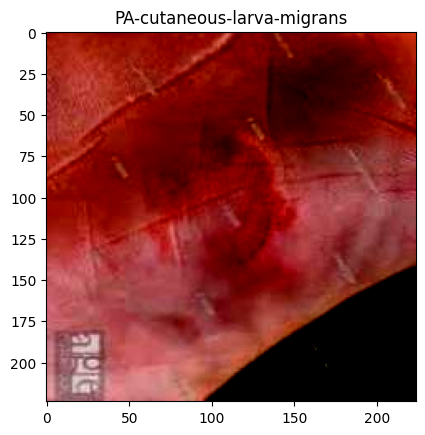

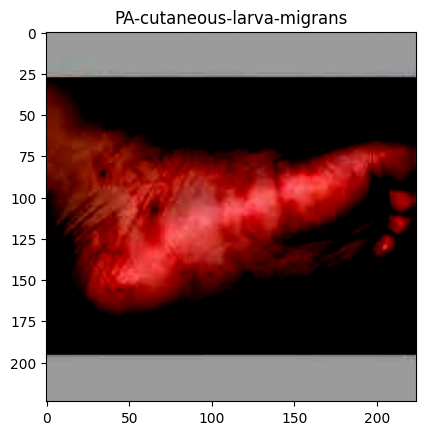

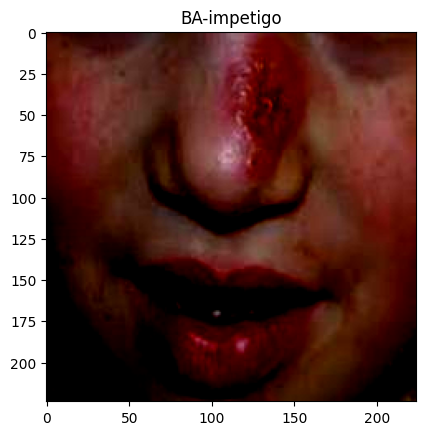

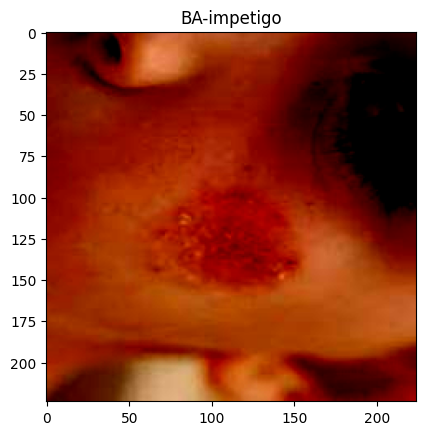

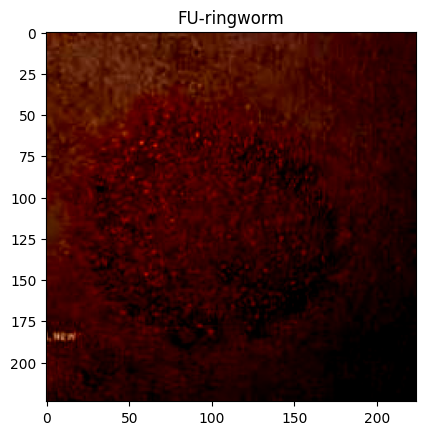

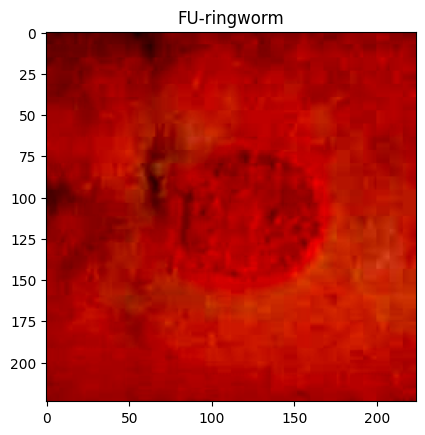

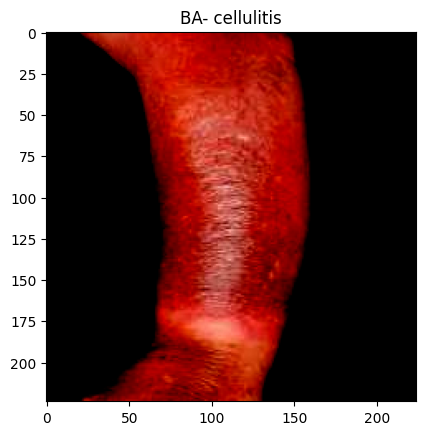

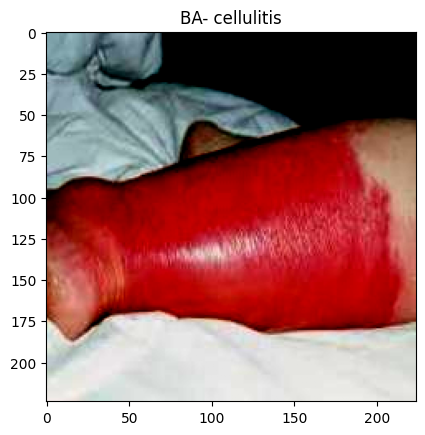

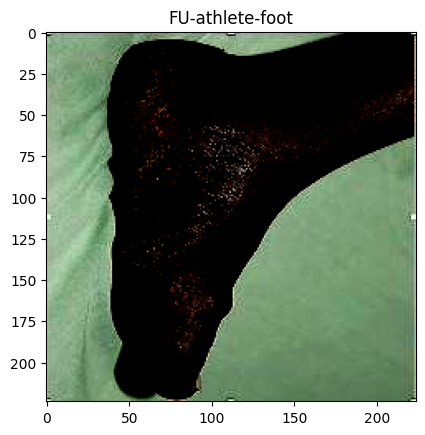

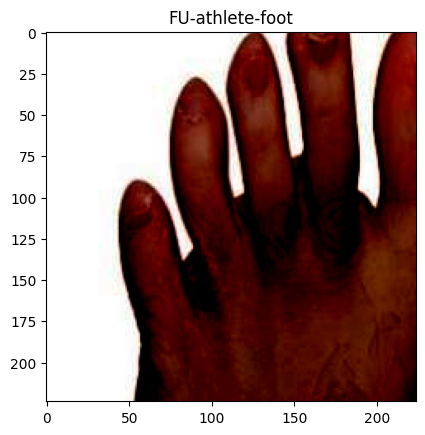

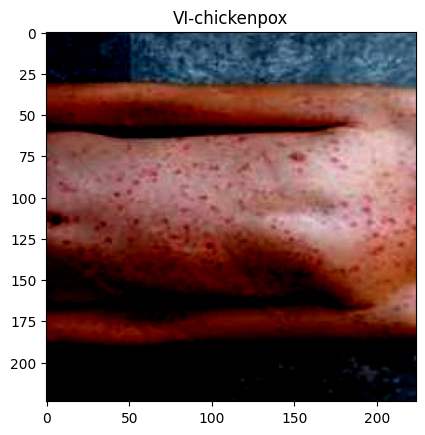

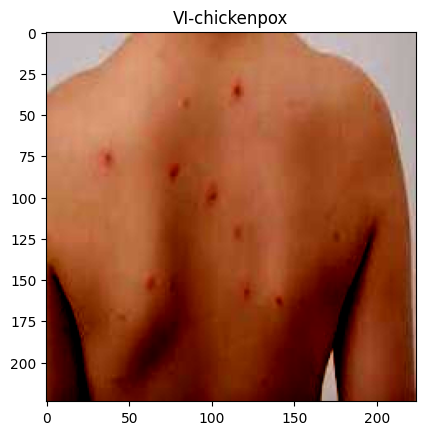

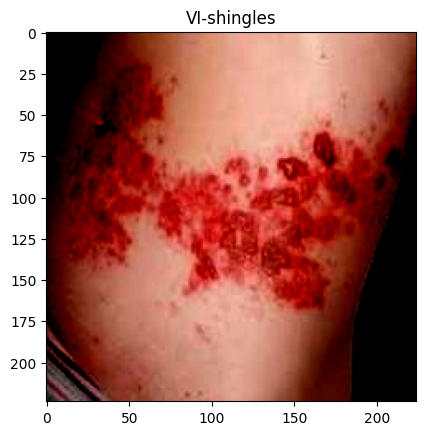

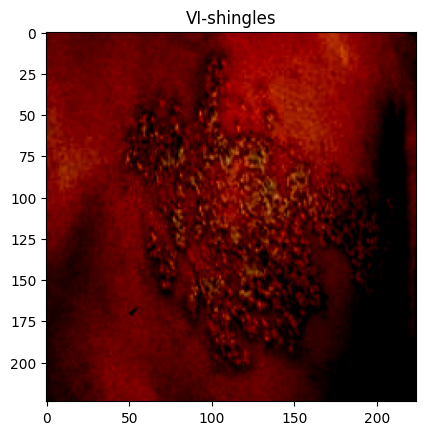

In [111]:
# Iterate through each folder in the dataset's root directory
for folder_name in os.listdir(folder_path):
    folder_path_full = os.path.join(folder_path, folder_name)

    # Check if it's a directory
    if os.path.isdir(folder_path_full):
        # Counter for displayed images in the current folder
        image_count = 0

        # Iterate through files in the folder
        for filename in os.listdir(folder_path_full):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                # Construct the full image path
                image_path = os.path.join(folder_path_full, filename)

                # Open the image using Pillow
                image = Image.open(image_path).convert("RGB")

                # Apply the same transformations as in your dataset
                transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5], std=[0.5])
                ])
                image = transform(image)

                # Display the image and its label
                plt.imshow(image.permute(1, 2, 0))
                plt.title(folder_name)  # Use folder name as label
                plt.show()

                # Increment the image count
                image_count += 1

                # Break if 2 images have been displayed for this folder
                if image_count >= 2:
                    break

In [112]:
def is_valid_image(img_path):
    """Check if an image file is valid (not corrupt)."""
    try:
        with Image.open(img_path) as img:
            img.verify()  # Verify if the image is valid
        return True
    except (UnidentifiedImageError, OSError):
        print(f"Corrupt image detected: {img_path}")
        return False

In [113]:
def clean_corrupt_images(root_dir, delete_corrupt=False):
    """Iterate through each folder and check for corrupt images."""
    total_images = 0
    corrupt_images = 0

    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)

        if os.path.isdir(folder_path):  # Ensure it's a folder
            for file in os.listdir(folder_path):
                if file.endswith((".jpg", ".jpeg", ".png")):
                    img_path = os.path.join(folder_path, file)
                    total_images += 1

                    if not is_valid_image(img_path):
                        corrupt_images += 1

                        if delete_corrupt:
                            os.remove(img_path)  # Delete the corrupt image
                            print(f"Deleted corrupt image: {img_path}")

    print(f"Total images checked: {total_images}")
    print(f"Corrupt images found: {corrupt_images}")

In [114]:
clean_corrupt_images(folder_path, delete_corrupt=True)

Total images checked: 547
Corrupt images found: 0


In [115]:
def standardize_images(root_dir, target_size=(224, 224), overwrite=True):
    """
    Standardize images in each folder by resizing and converting to RGB.

    Parameters:
    - root_dir: The root directory containing folders of images.
    - target_size: Tuple (width, height) to resize images.
    - overwrite: If True, replaces the original image. If False, saves as new file.
    """
    total_images = 0
    processed_images = 0

    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)

        if os.path.isdir(folder_path):  # Ensure it's a folder
            for file in os.listdir(folder_path):
                if file.endswith((".jpg", ".jpeg", ".png")):
                    img_path = os.path.join(folder_path, file)
                    total_images += 1

                    try:
                        with Image.open(img_path) as img:
                            img = img.convert("RGB")  # Convert to RGB (if needed)
                            img = img.resize(target_size, Image.LANCZOS)  # Resize

                            if overwrite:
                                img.save(img_path)  # Replace original
                            else:
                                new_path = os.path.join(folder_path, f"std_{file}")
                                img.save(new_path)  # Save new standardized image

                            processed_images += 1

                    except Exception as e:
                        print(f"Error processing {img_path}: {e}")

    print(f"Total images found: {total_images}")
    print(f"Images successfully standardized: {processed_images}")

In [116]:
standardize_images(folder_path, overwrite=True, target_size=(224, 224))

Total images found: 547
Images successfully standardized: 547


In [117]:
def compute_image_hash(image_path):
    """Generate a hash for an image file to identify duplicates."""
    try:
        with Image.open(image_path) as img:
            img = img.convert("RGB")  # Convert to consistent format
            img_bytes = img.tobytes()  # Get image byte data
            return hashlib.md5(img_bytes).hexdigest()  # Compute MD5 hash
    except Exception as e:
        print(f"Error hashing {image_path}: {e}")
        return None

In [101]:
def remove_duplicate_images(root_dir):
    """
    Removes duplicate images in each folder based on image content.

    - root_dir: The path containing subfolders of images.
    """
    total_removed = 0

    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)

        if os.path.isdir(folder_path):  # Ensure it's a directory
            hashes = set()  # Set to store unique image hashes

            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)

                if filename.lower().endswith((".jpg", ".jpeg", ".png")):  # Ensure it's an image
                    try:
                        img = Image.open(img_path)
                        img_hash = imagehash.average_hash(img)

                        if img_hash in hashes:
                            total_removed += 1
                            os.remove(img_path)  # Remove duplicate
                            print(f"Removed duplicate: {filename}")
                        else:
                            hashes.add(img_hash)  # Store unique hash
                    except Exception as e:
                        print(f"Skipping unreadable file: {filename}, Error: {e}")

    print(f"Total duplicate images removed: {total_removed}")

In [103]:
remove_duplicate_images(folder_path)

Removed duplicate: 78_PA-cutaneous-larva-migrans (5).jpg
Removed duplicate: 102_PA-cutaneous-larva-migrans (57).jpg
Removed duplicate: 98_PA-cutaneous-larva-migrans (22).jpg
Removed duplicate: 100_PA-cutaneous-larva-migrans (3).jpeg
Removed duplicate: 67_PA-cutaneous-larva-migrans (19).jpg
Removed duplicate: 63_PA-cutaneous-larva-migrans (54).jpg
Removed duplicate: 59_PA-cutaneous-larva-migrans (32).jpg
Removed duplicate: 76_PA-cutaneous-larva-migrans (4).jpg
Removed duplicate: 70_PA-cutaneous-larva-migrans (28).jpg
Removed duplicate: 32_PA-cutaneous-larva-migrans (9).jpg
Removed duplicate: 23_PA-cutaneous-larva-migrans (20).jpg
Removed duplicate: 24_PA-cutaneous-larva-migrans (4).jpeg
Removed duplicate: 29_PA-cutaneous-larva-migrans (4).jpeg
Removed duplicate: 28_PA-cutaneous-larva-migrans (54).jpg
Removed duplicate: 41_PA-cutaneous-larva-migrans (4).jpeg
Removed duplicate: 38_PA-cutaneous-larva-migrans (19).jpg
Removed duplicate: 40_PA-cutaneous-larva-migrans (64).jpg
Removed duplica

In [104]:
clean_corrupt_images(folder_path, delete_corrupt=True)

Total images checked: 547
Corrupt images found: 0


In [118]:
def normalize_and_save_image(img_path, save_path, target_size=(224, 224)):
    """
    Loads, normalizes, and saves an image using TensorFlow.

    - img_path: Path to the original image
    - save_path: Path to save the normalized image
    - target_size: Desired image size (default: 224x224)
    """

    try:
      # Load the image
      img = tf.io.read_file(img_path)
      img = tf.image.decode_jpeg(img, channels=3)

      # Resize to target size
      img = tf.image.resize(img, target_size)

      # Normalize the pixel value to [0, 1]
      img = img / 255.0

      # Converting back to uint8 format (0-255) for saving
      img = tf.image.convert_image_dtype(img, tf.uint8)

      # Save the image
      img_encoded = tf.io.encode_jpeg(img)
      tf.io.write_file(save_path, img_encoded)

      return True
    except Exception as e:
      print(f"Error processing {img_path}: {e}")
      return False

In [119]:
def normalize_images_in_folders(root_dir, output_dir):
    """
    Normalizes all images in subfolders under root_dir and saves them to output_dir.

    - root_dir: Path containing disease folders with images
    - output_dir: Path to save normalized images
    """
    os.makedirs(output_dir, exist_ok=True)  # Create output directory if not exist
    total_normalized = 0

    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)
        save_folder = os.path.join(output_dir, folder)
        os.makedirs(save_folder, exist_ok=True)  # Create subfolder in output

        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith((".jpg", ".jpeg", ".png")):
                    img_path = os.path.join(folder_path, file)
                    save_path = os.path.join(save_folder, file)

                    if normalize_and_save_image(img_path, save_path):
                        total_normalized += 1

    print(f"Total images normalized: {total_normalized}")

In [120]:
normalize_data = "/content/drive/MyDrive/Skinn-data/Skin-disease-dataset/Normalize_data"
normalize_images_in_folders(folder_path, normalize_data)

Total images normalized: 547


In [129]:
def augment_image(image):
    """
    Applies random augmentations to a given image tensor.

    - Random flip (horizontal & vertical)
    - Random rotation (up to 20 degrees)
    - Random brightness change
    - Random zoom
    """
    # Randomly flip the image
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Random rotation (up to 20 degrees)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Random brightness adjustment
    image = tf.image.random_brightness(image, max_delta=0.2)

    # Random zoom by cropping and resizing
    crop_size = tf.random.uniform(shape=[], minval=180, maxval=224, dtype=tf.int32)  # Crop between 180-224 px
    image = tf.image.resize_with_crop_or_pad(image, crop_size, crop_size)
    image = tf.image.resize(image, [224, 224])

    return image

In [130]:
def augment_and_save_images(input_dir, output_dir, augment_count=3):
    """
    Applies augmentation to all images in input_dir and saves them to output_dir.

    - augment_count: Number of augmented copies per image.
    """
    os.makedirs(output_dir, exist_ok=True)
    total_augmented = 0

    for folder in os.listdir(input_dir):
        folder_path = os.path.join(input_dir, folder)
        save_folder = os.path.join(output_dir, folder)
        os.makedirs(save_folder, exist_ok=True)

        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith((".jpg", ".jpeg", ".png")):
                    img_path = os.path.join(folder_path, file)

                    try:
                        # Load image
                        img = tf.io.read_file(img_path)
                        img = tf.image.decode_jpeg(img, channels=3)
                        img = tf.image.resize(img, [224, 224])  # Ensure size

                        # Save original image
                        original_save_path = os.path.join(save_folder, file)
                        img_encoded = tf.io.encode_jpeg(tf.cast(img, tf.uint8))
                        tf.io.write_file(original_save_path, img_encoded)

                        # Apply augmentations
                        for i in range(augment_count):
                            augmented_img = augment_image(img)
                            aug_save_path = os.path.join(save_folder, f"aug_{i}_{file}")
                            img_encoded = tf.io.encode_jpeg(tf.cast(augmented_img, tf.uint8))
                            tf.io.write_file(aug_save_path, img_encoded)
                            total_augmented += 1

                    except Exception as e:
                        print(f"Error processing {img_path}: {e}")

    print(f"Total augmented images created: {total_augmented}")

In [131]:
augumented_folder = "/content/drive/MyDrive/Skinn-data/Skin-disease-dataset/augumented_data"

augment_and_save_images(normalize_data, augumented_folder)

Total augmented images created: 1641


In [132]:
def generate_image_statistics(dataset_path):
    """Generate and display 7 different image analysis graphs."""
    categories, image_counts = [], []
    widths, heights, avg_intensity, avg_brightness, avg_contrast = [], [], [], [], []

    # Process each folder in the dataset
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            count = 0
            for file in os.listdir(folder_path):
                if file.endswith((".jpg", ".jpeg", ".png")):
                    img_path = os.path.join(folder_path, file)
                    try:
                        with Image.open(img_path) as img:
                            count += 1
                            widths.append(img.width)
                            heights.append(img.height)

                        # Read with OpenCV for pixel analysis
                        img_cv = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                        if img_cv is not None:
                            avg_intensity.append(np.mean(img_cv))
                            avg_brightness.append(np.mean(img_cv) / 255.0)  # Normalize brightness
                            avg_contrast.append(np.std(img_cv))  # Standard deviation for contrast

                    except Exception as e:
                        print(f"Error processing {img_path}: {e}")

            categories.append(folder)
            image_counts.append(count)

    # Set up subplots
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    fig.suptitle("Image Dataset Analysis", fontsize=16)

    # 1. Number of Images Per Category
    axes[0, 0].bar(categories, image_counts, color='skyblue')
    axes[0, 0].set_title("Image Distribution Across Categories")
    axes[0, 0].set_xlabel("Disease Category")
    axes[0, 0].set_ylabel("Number of Images")
    axes[0, 0].tick_params(axis='x', rotation=45)

    # 2. Image Size Distribution
    axes[0, 1].hist(widths, bins=20, alpha=0.5, label="Width", color="blue")
    axes[0, 1].hist(heights, bins=20, alpha=0.5, label="Height", color="red")
    axes[0, 1].set_title("Distribution of Image Sizes")
    axes[0, 1].set_xlabel("Pixels")
    axes[0, 1].set_ylabel("Frequency")
    axes[0, 1].legend()

    # 3. Average Pixel Intensity Distribution
    axes[0, 2].hist(avg_intensity, bins=30, color='green', alpha=0.7)
    axes[0, 2].set_title("Pixel Intensity Distribution")
    axes[0, 2].set_xlabel("Intensity")
    axes[0, 2].set_ylabel("Frequency")

    # 4. Aspect Ratio Distribution
    aspect_ratios = np.array(widths) / np.array(heights)
    axes[1, 0].hist(aspect_ratios, bins=20, color='purple', alpha=0.7)
    axes[1, 0].set_title("Aspect Ratio Distribution")
    axes[1, 0].set_xlabel("Aspect Ratio (Width/Height)")
    axes[1, 0].set_ylabel("Frequency")

    # 5. Brightness Distribution
    axes[1, 1].hist(avg_brightness, bins=30, color='gold', alpha=0.7)
    axes[1, 1].set_title("Brightness Distribution")
    axes[1, 1].set_xlabel("Brightness (0-1)")
    axes[1, 1].set_ylabel("Frequency")

    # 6. Contrast Distribution
    axes[1, 2].hist(avg_contrast, bins=30, color='orange', alpha=0.7)
    axes[1, 2].set_title("Contrast Distribution")
    axes[1, 2].set_xlabel("Contrast (Std Dev)")
    axes[1, 2].set_ylabel("Frequency")

    # 7. Color Distribution (RGB Histogram) for Sample Image
    sample_image = os.path.join(dataset_path, os.listdir(dataset_path)[0], os.listdir(os.path.join(dataset_path, os.listdir(dataset_path)[0]))[0])
    img_sample = cv2.imread(sample_image)
    colors = ('b', 'g', 'r')
    for i, color in enumerate(colors):
        hist = cv2.calcHist([img_sample], [i], None, [256], [0, 256])
        axes[2, 0].plot(hist, color=color)
    axes[2, 0].set_title("RGB Color Distribution")
    axes[2, 0].set_xlabel("Pixel Value")
    axes[2, 0].set_ylabel("Frequency")

    # Hide extra subplots
    axes[2, 1].axis('off')
    axes[2, 2].axis('off')

    # Show all graphs
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


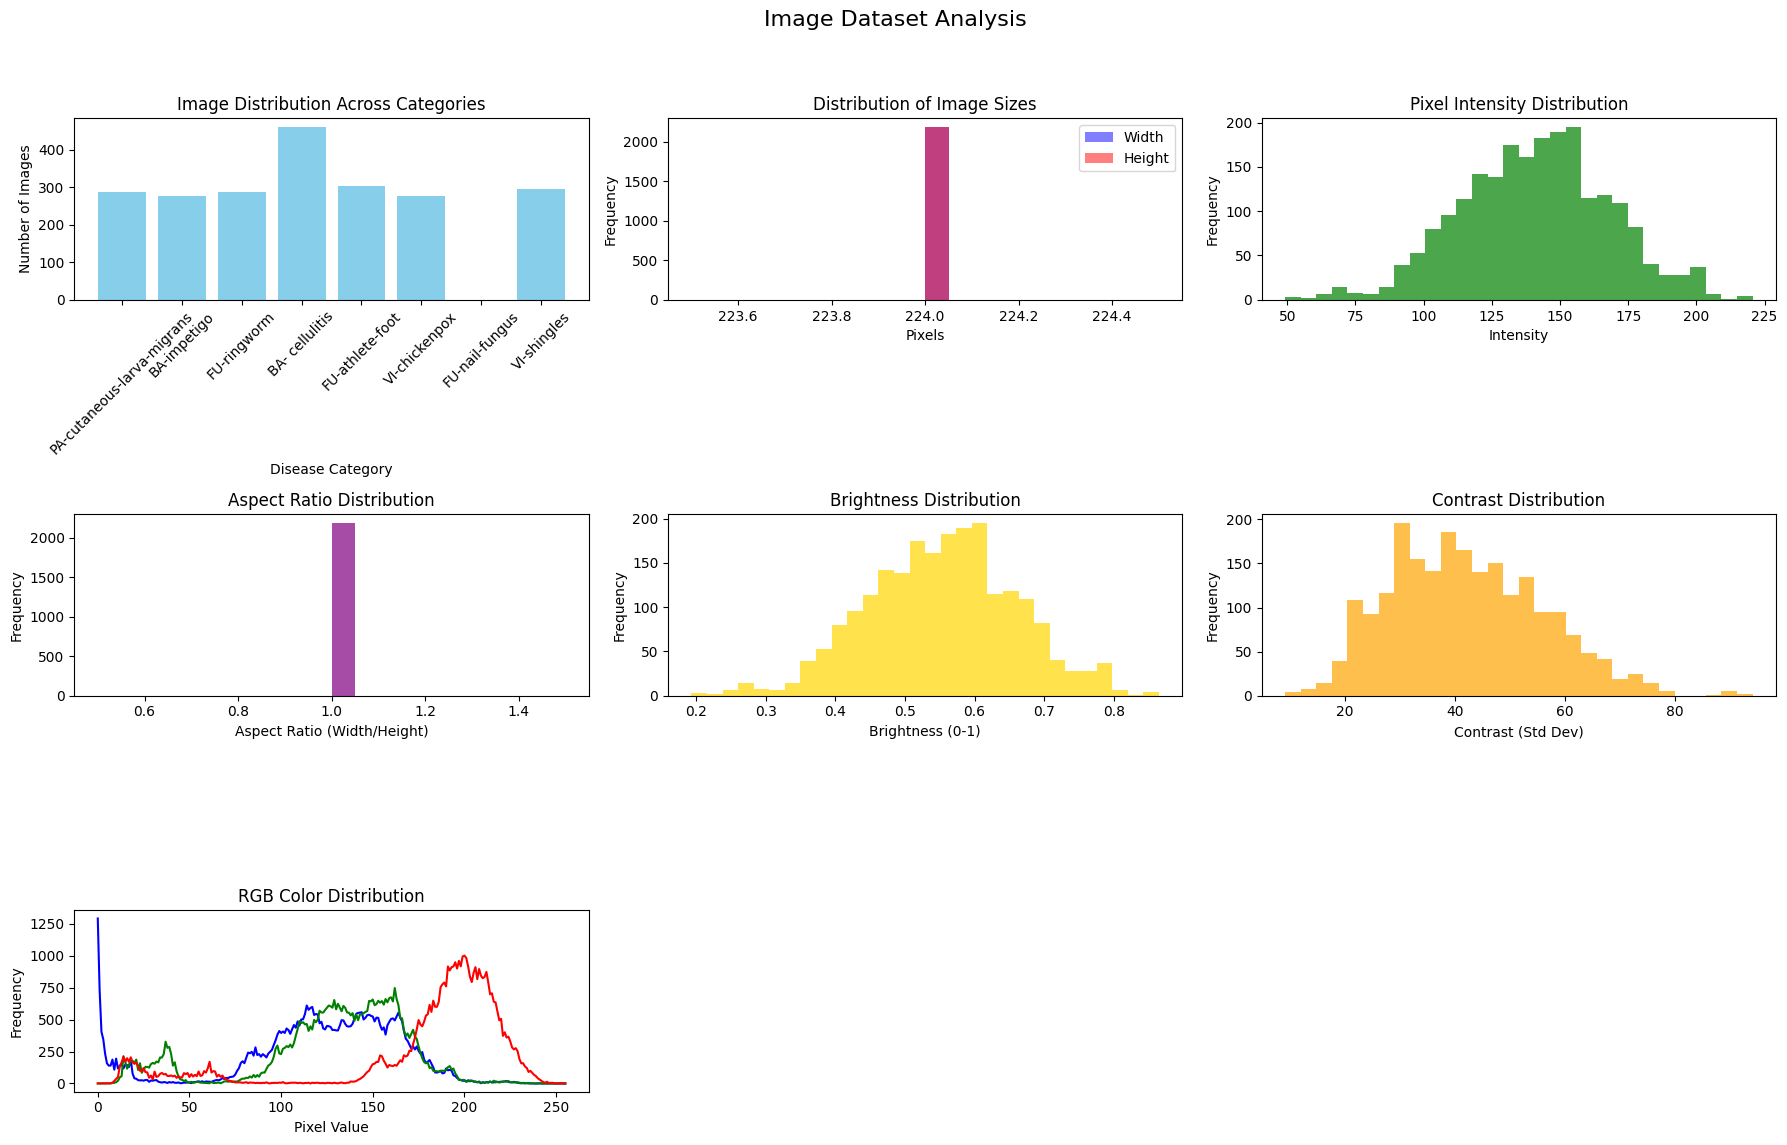

In [133]:
generate_image_statistics(augumented_folder)

In [135]:
def plot_class_distribution(folder_path):
  class_count = {}
  for folder in os.listdir(folder_path):
    folder_path_full = os.path.join(folder_path, folder)
    if os.path.isdir(folder_path_full):
      class_count[folder] = len(os.listdir(folder_path_full))

  plt.figure(figsize=(15,15))
  plt.bar(class_count.keys(), class_count.values(), color='skyblue')
  plt.xlabel('Class')
  plt.ylabel('Number of Images')
  plt.title('Class Distribution')
  plt.xticks(rotation=90)
  plt.show()

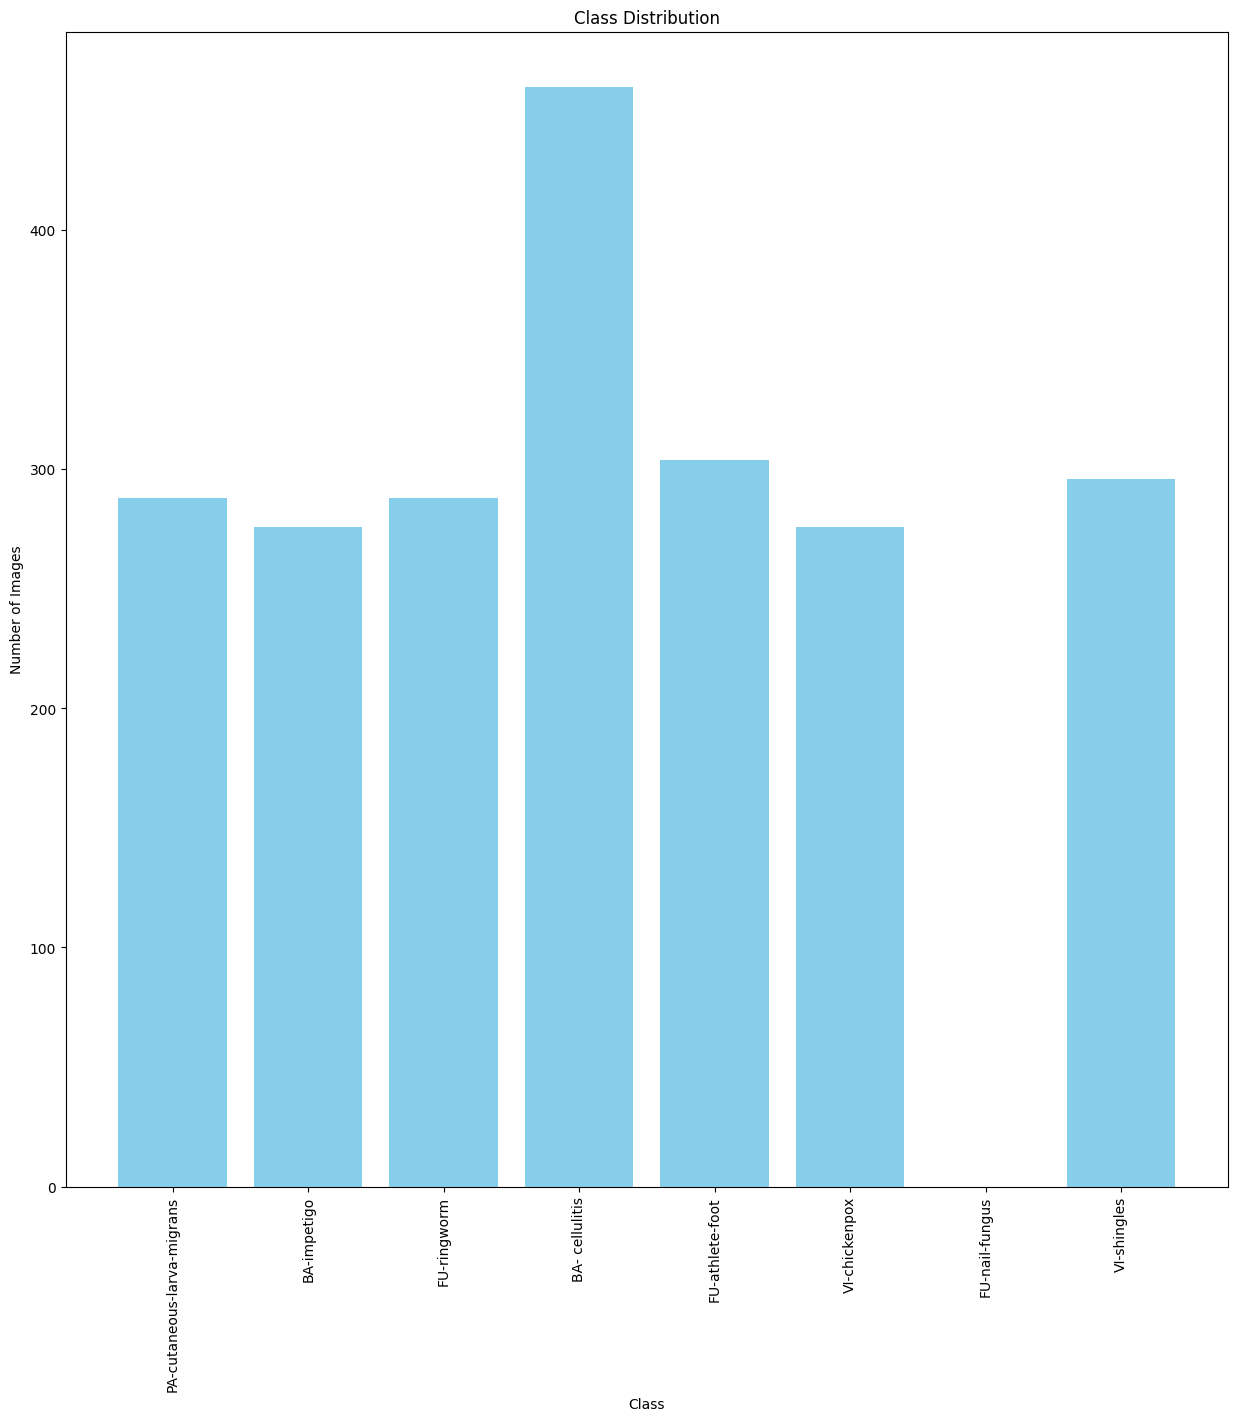

In [137]:
plot_class_distribution(augumented_folder)

In [138]:
def plot_image_size_distribution(root_dir):
    sizes = []
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                img_path = os.path.join(class_path, file)
                try:
                    with Image.open(img_path) as img:
                        sizes.append(img.size)
                except:
                    continue

    widths, heights = zip(*sizes)
    plt.figure(figsize=(10, 5))
    plt.scatter(widths, heights, alpha=0.5, color='green')
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.title("Image Size Distribution")
    plt.show()

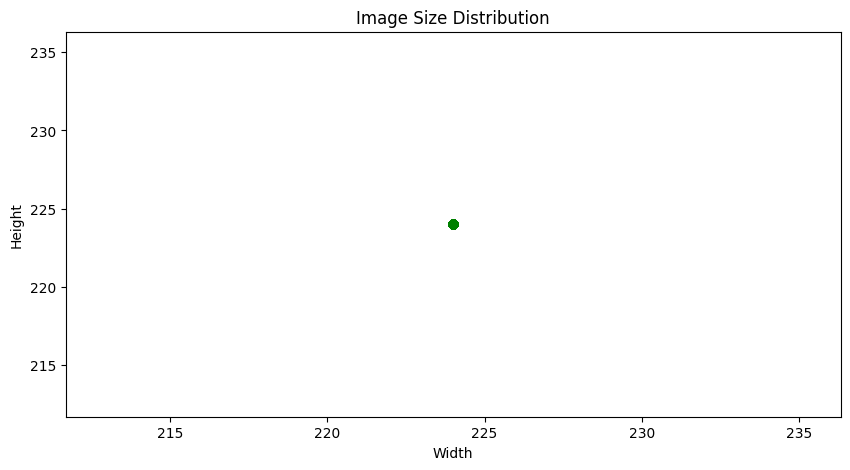

In [139]:
plot_image_size_distribution(augumented_folder)

In [140]:
def plot_aspect_ratio_distribution(root_dir):
    aspect_ratios = []
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                img_path = os.path.join(class_path, file)
                try:
                    with Image.open(img_path) as img:
                        aspect_ratios.append(img.size[0] / img.size[1])
                except:
                    continue

    plt.figure(figsize=(10, 5))
    plt.hist(aspect_ratios, bins=20, color='purple', alpha=0.7)
    plt.xlabel("Aspect Ratio (Width / Height)")
    plt.ylabel("Count")
    plt.title("Aspect Ratio Distribution")
    plt.show()

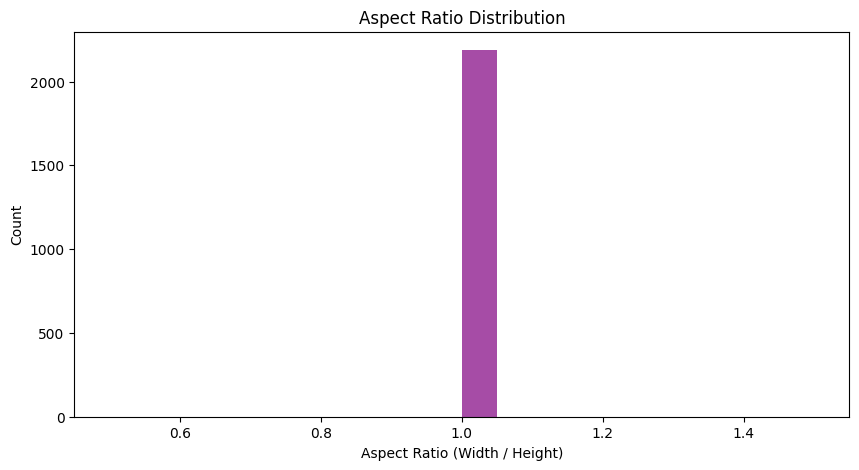

In [141]:
plot_aspect_ratio_distribution(augumented_folder)

In [142]:
def plot_mean_pixel_intensity(root_dir):
    mean_intensities = []
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                img_path = os.path.join(class_path, file)
                try:
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    mean_intensities.append(np.mean(img))
                except:
                    continue

    plt.figure(figsize=(10, 5))
    plt.hist(mean_intensities, bins=30, color='orange', alpha=0.7)
    plt.xlabel("Mean Pixel Intensity")
    plt.ylabel("Count")
    plt.title("Mean Pixel Intensity Distribution")
    plt.show()

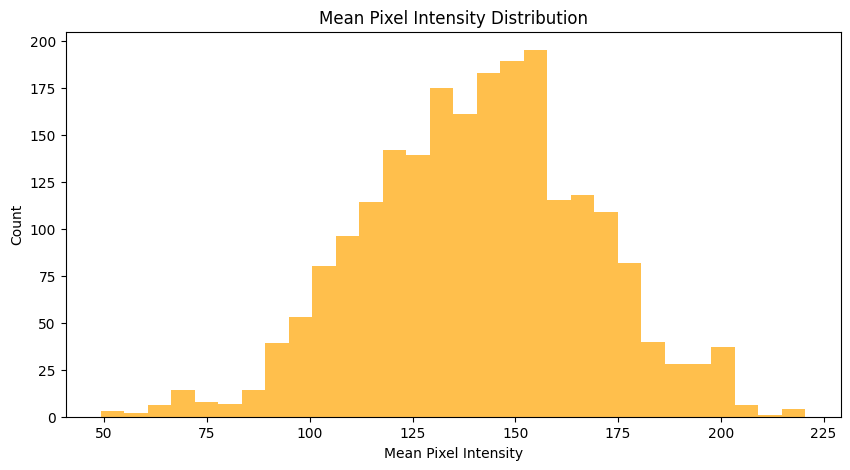

In [143]:
plot_mean_pixel_intensity(augumented_folder)

In [145]:
def plot_color_distribution(root_dir):
  color_channels = {'Red': [], "Green": [], "Blue": []}

  for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    if os.path.isdir(folder_path):
      for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)
        try:
          img = cv2.imread(img_path)
          if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            r, g, b = cv2.split(img)
            color_channels['Red'].extend(r.flatten())
            color_channels['Green'].extend(g.flatten())
            color_channels['Blue'].extend(b.flatten())
        except:
          continue

    plt.figure(figsize=(10, 5))
    plt.hist(color_channels["Red"], bins=30, color='red', alpha=0.5, label='Red')
    plt.hist(color_channels["Green"], bins=30, color='green', alpha=0.5, label='Green')
    plt.hist(color_channels["Blue"], bins=30, color='blue', alpha=0.5, label='Blue')
    plt.xlabel("Color Intensity")
    plt.ylabel("Count")
    plt.title("Color Distribution")
    plt.legend()
    plt.show()

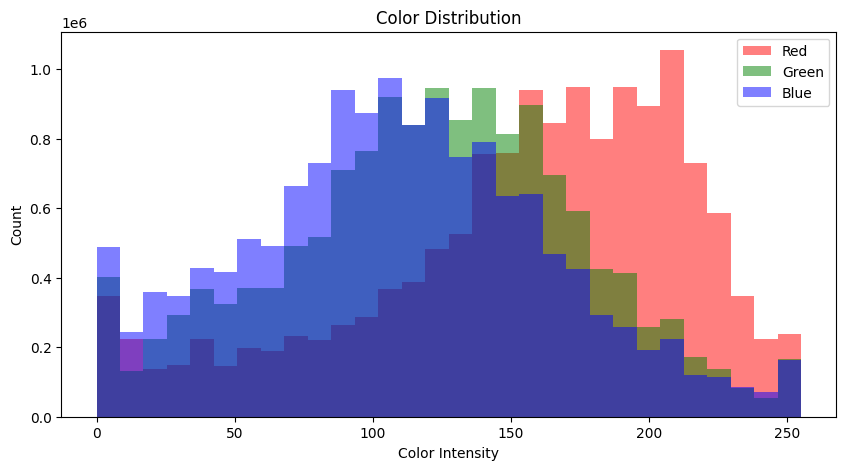

In [ ]:
plot_color_distribution(augumented_folder)

In [2]:
def plot_blur_detection(root_dir):
    blur_values = []

    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                img_path = os.path.join(class_path, file)
                try:
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        blur_value = cv2.Laplacian(img, cv2.CV_64F).var()
                        blur_values.append(blur_value)
                except:
                    continue

    plt.figure(figsize=(10, 5))
    plt.hist(blur_values, bins=30, color='brown', alpha=0.7)
    plt.xlabel("Laplacian Variance")
    plt.ylabel("Count")
    plt.title("Blur Detection (Higher is Sharper)")
    plt.show()

In [4]:
plot_blur_detection(augumented_folder)

NameError: name 'augumented_folder' is not defined